In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import sys
import pickle
from itertools import product

import numpy as np
import pandas as pd
import scipy.stats as stats

from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns



In [3]:
repo_dir = Path('../..')

In [4]:
if str(repo_dir) not in sys.path:
    sys.path.append(str(repo_dir))
    
from analysis.curve_fitting.src.fitting_functions import LOSS_FUNCTIONS
from analysis.curve_fitting.src.utils import apply_filters, load_yaml, convert_loss_parameters, convert_loss_parameters_batch

from visualization.src.utils import COLOR_PALETTES, set_ticks, save_figs
from visualization.src.visualize import plot_reg, plot_reg_bivariate, plot_confidence_intervals



In [5]:
args = {
    'results_csv': repo_dir / 'results' / 'benchmark_scores_local.csv',
}

In [6]:
results_csv = args['results_csv']

df_results = pd.read_csv(results_csv)
df_results['total_flops'] = df_results['flops'] * df_results['n_samples_seen']

## Load Experiment Configuration

In [7]:
analysis_dir = repo_dir / 'analysis'
config_dir = analysis_dir / 'curve_fitting/configs/region'
results_dir = analysis_dir / 'curve_fitting/fitting_results'
# results_dir = analysis_dir / 'curve_fitting/fitting_results_region'

In [8]:
config = {
    'data_filters': {
        'set_filters': {
            'region': [
                'V1',
                'V2',
                'V4',
                'IT',
                'Behavioral'
                ],
            'dataset': [
                'imagenet',
                'ecoset',
                ]
            },
    'boolean_filters': {
        'equals_false': [
            'is_pretrained',
            'is_random',
            'is_ssl',
            'is_adv',
            'is_ablation'
            ]
        },
    
    # 'group_by': {
    #     'avg_score': {
    #         'keys': [
    #             'model_id',
    #             'arch',
    #             'dataset',
    #             'flops',
    #             'n_params',
    #             'n_samples',
    #             'n_samples_seen',
    #             'total_flops',
    #             'arch_family',
    #             'samples_per_class',
    #             'benchmark_name',
    #             'region'
    #         ],
    #         'reduce': {'score': 'mean'}}},
    # 'arch_families_samples': {
    #     'arch_family': [
    #         'ConvNeXt',
    #         'ConvNeXtFlex',
    #         'ViT',
    #         'ViTFlex',
    #         ],
    # 'samples_per_class': [0, 300]},
    'combine_arch_families': True,
    }
}

## Apply Data Filters

In [9]:
df = apply_filters(df_results, config['data_filters'])

In [10]:
df.isna().sum()

model_id                0
arch_family             0
arch                    0
macs                    0
flops                   0
dataset                 0
n_params                0
n_samples               0
samples_per_class       0
n_samples_seen          0
n_epochs                0
seed                    0
benchmark_id            0
benchmark_name          0
region                  0
score                   0
acc                     0
ssl_method           3100
is_pretrained           0
is_random               0
is_ssl                  0
is_ablation             0
is_open_clip            0
is_adv                  0
total_flops             0
dtype: int64

## Compute confidence intervals

In [11]:
random_state = 42
num_bootstraps = 1000
fraction = 1

rng = np.random.default_rng(random_state)
all_samples = int(len(df)/5)
num_samples = int(fraction * all_samples)
random_indices = rng.integers(0, all_samples, size=(num_bootstraps, num_samples))

In [12]:
df_fits = []

for i, region in tqdm(enumerate(['V1', 'V2', 'V4', 'IT', 'Behavioral']), total=5):
    for j, indices in tqdm(enumerate(random_indices), leave=False, total=num_bootstraps):
        data = df[df.region == region].copy().reset_index(drop=True)
        data = data.iloc[indices]
        
        x = data['acc']
        y = data['score']
        reg = stats.linregress(x, y)
        df_fits.append({
            'region': region,
            'slope': reg.slope,
            'intercept': reg.intercept,
            'rvalue': reg.rvalue,
            'pvalue': reg.pvalue,
            'stderr': reg.stderr,
        })
        
df_fits = pd.DataFrame(df_fits)
df_fits

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

,region,slope,intercept,rvalue,pvalue,stderr
0,V1,0.138991,0.122343,0.520845,2.084684e-44,0.009164
1,V1,0.125963,0.134286,0.494225,1.688579e-39,0.008913
2,V1,0.127190,0.133269,0.492712,3.117512e-39,0.009036
3,V1,0.127629,0.129300,0.498380,3.087134e-40,0.008931
4,V1,0.138240,0.121855,0.512248,8.952746e-43,0.009323
...,...,...,...,...,...,...
4995,Behavioral,0.532656,0.016858,0.956274,0.000000e+00,0.006553
4996,Behavioral,0.531272,0.013289,0.958624,0.000000e+00,0.006346
4997,Behavioral,0.541036,0.011039,0.961515,0.000000e+00,0.006219
4998,Behavioral,0.532359,0.018735,0.964665,0.000000e+00,0.005849


In [13]:
data = df.copy()
data = data.groupby(['model_id', 'acc']).agg({'score': 'mean'}).reset_index()
x = data['acc']
y = data['score']
reg = stats.linregress(x, y)
avg_r = reg.rvalue

## Visualize

#### Plotting settings

In [14]:
multiplier = 1.1
X_str = r'$$\tilde{C}$$'
linewidth = 3.0
alpha_scatter = 0.2
alpha_ci = 0.2
alpha_fit = 1.0
fig_multiplier = 0.75
fig_multiplier = 0.6
fig_multiplier = 0.5
figsize = (10, 8)
figsize = (fig_multiplier * figsize[0], fig_multiplier * figsize[1])

color_palette_regions = COLOR_PALETTES['regions']
color_palette_samples = COLOR_PALETTES['samples']
color_1, color_2 = color_palette_regions[0], color_palette_regions[-1]

In [15]:
df_neuro = df.groupby(['model_id', 'arch_family', 'n_samples_seen', 'acc']).agg({'score': 'mean'}).reset_index()
df_behav = df[df.region == 'Behavioral']

In [16]:
arch_order = {
    'AlexNet': 0,
    'ConvNeXt': 1,
    'CORnet-S': 2,
    'ViT': 3,
    'EfficientNet': 4,
    'ResNet': 5,
}

df_neuro['arch_order'] = df_neuro['arch_family'].map(arch_order)
df_neuro = df_neuro.sort_values('arch_order')

df_behav['arch_order'] = df_behav['arch_family'].map(arch_order)
df_behav = df_behav.sort_values('arch_order')

/var/folders/6_/9qd_srs52fz062xwc4ms2xg80000gn/T/ipykernel_2086/4121563826.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_behav['arch_order'] = df_behav['arch_family'].map(arch_order)


#### Plot 1

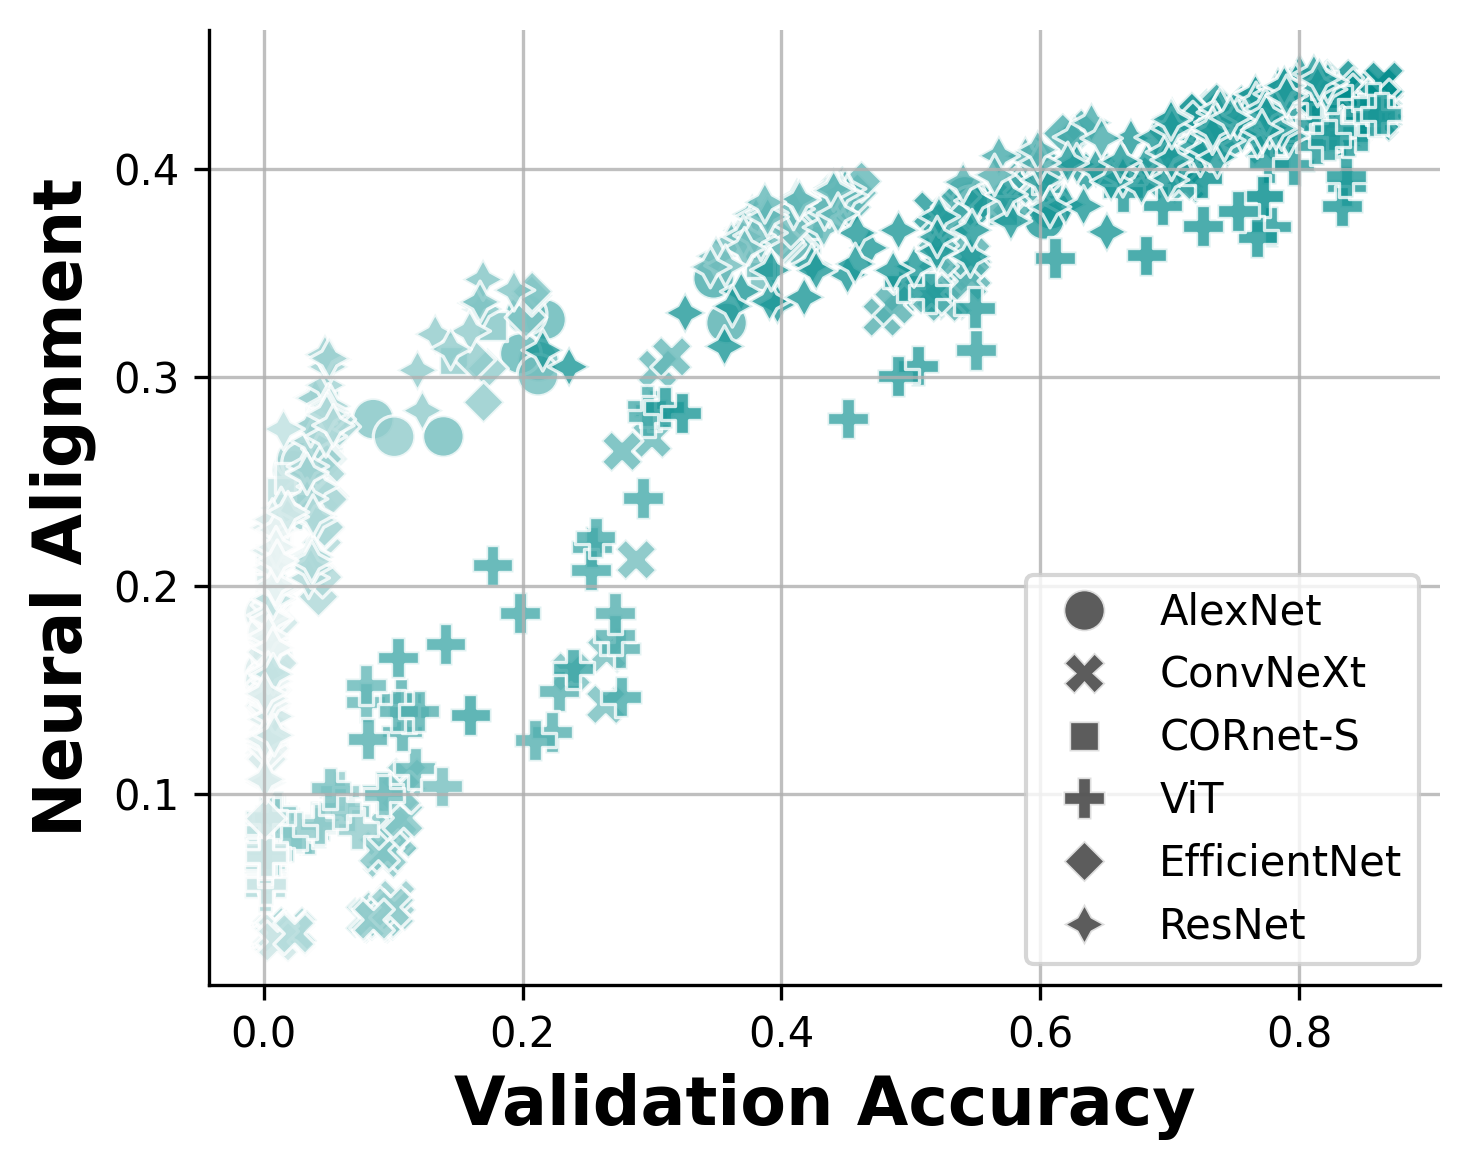

In [17]:
fig, axes = plt.subplots(1, 1, figsize=figsize, dpi=300)
ax = axes

data_region = df_neuro.copy()
# data_region.sort_values(['arch_family'], inplace=True)
sns.scatterplot(data=data_region, x='acc', y='score', hue='n_samples_seen', hue_norm=LogNorm(), ax=ax, markers=True, style='arch_family', s=100, alpha=0.8, palette=color_palette_samples)


# Set the labels
ax.set_ylabel('Neural Alignment', fontsize=16, fontweight='bold')
ax.set_xlabel('Validation Accuracy', fontsize=16, fontweight='bold')

# Set the ticks
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.8)
ax.grid(True)

ax.spines[['right', 'top']].set_visible(False)

### Legend
handles, labels = ax.get_legend_handles_labels()
handles, labels = handles[-6:], labels[-6:]
ax.legend(handles=handles, labels=labels, loc='lower right')


    
plt.tight_layout()
# plt.savefig('../figures/regions_compare.svg', bbox_inches='tight')

figures_dir = '../figures'
fig_name = 'fig6_corr_neuro'
formats = ['pdf', 'png', 'svg']
save_figs(figures_dir, fig_name, formats=formats)

#### Plot 2

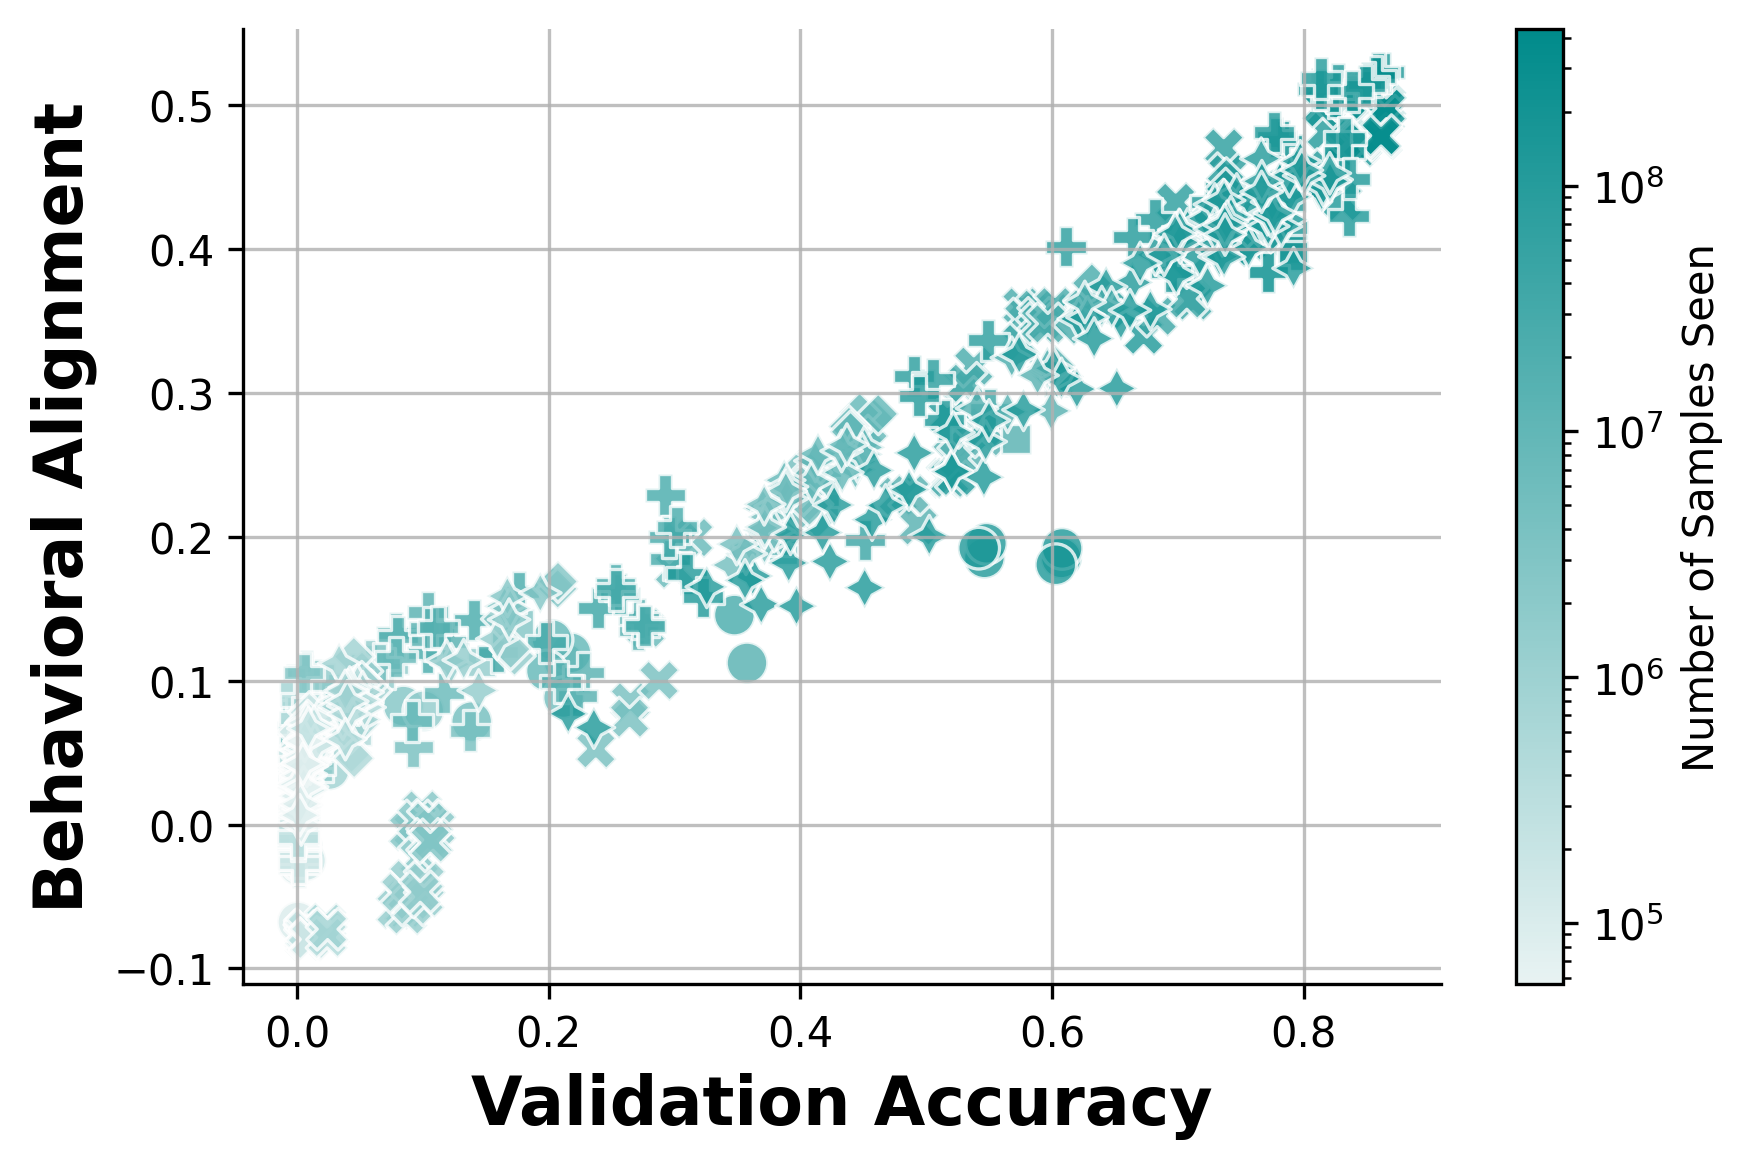

In [18]:
figsize = (12, 8)
figsize = (fig_multiplier * figsize[0], fig_multiplier * figsize[1])
fig, axes = plt.subplots(1, 1, figsize=figsize, dpi=300)
ax = axes

data_region = df_behav.copy()
# data_region.sort_values(['arch_family'], inplace=True)
sns.scatterplot(data=data_region, x='acc', y='score', hue='n_samples_seen', hue_norm=LogNorm(), ax=ax, markers=True, style='arch_family', s=100, alpha=0.8, palette=color_palette_samples)

### Colorbar
sm = plt.cm.ScalarMappable(cmap= color_palette_samples, norm=LogNorm())
sm.set_clim(data_region['n_samples_seen'].min(), data_region['n_samples_seen'].max())
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Number of Samples Seen')

# Set the labels
ax.set_ylabel('Behavioral Alignment', fontsize=16, fontweight='bold')
ax.set_xlabel('Validation Accuracy', fontsize=16, fontweight='bold')

# Set the ticks
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.8)
ax.grid(True)

ax.spines[['right', 'top']].set_visible(False)

### Legend
handles, labels = ax.get_legend_handles_labels()
handles, labels = handles[-6:], labels[-6:]
ax.legend(handles=handles, labels=labels, loc='lower right')
ax.legend().remove()


    
plt.tight_layout()
# plt.savefig('../figures/regions_compare.svg', bbox_inches='tight')


figures_dir = '../figures'
fig_name = 'fig6_corr_behav'
formats = ['pdf', 'png', 'svg']
save_figs(figures_dir, fig_name, formats=formats)

#### Plot 3

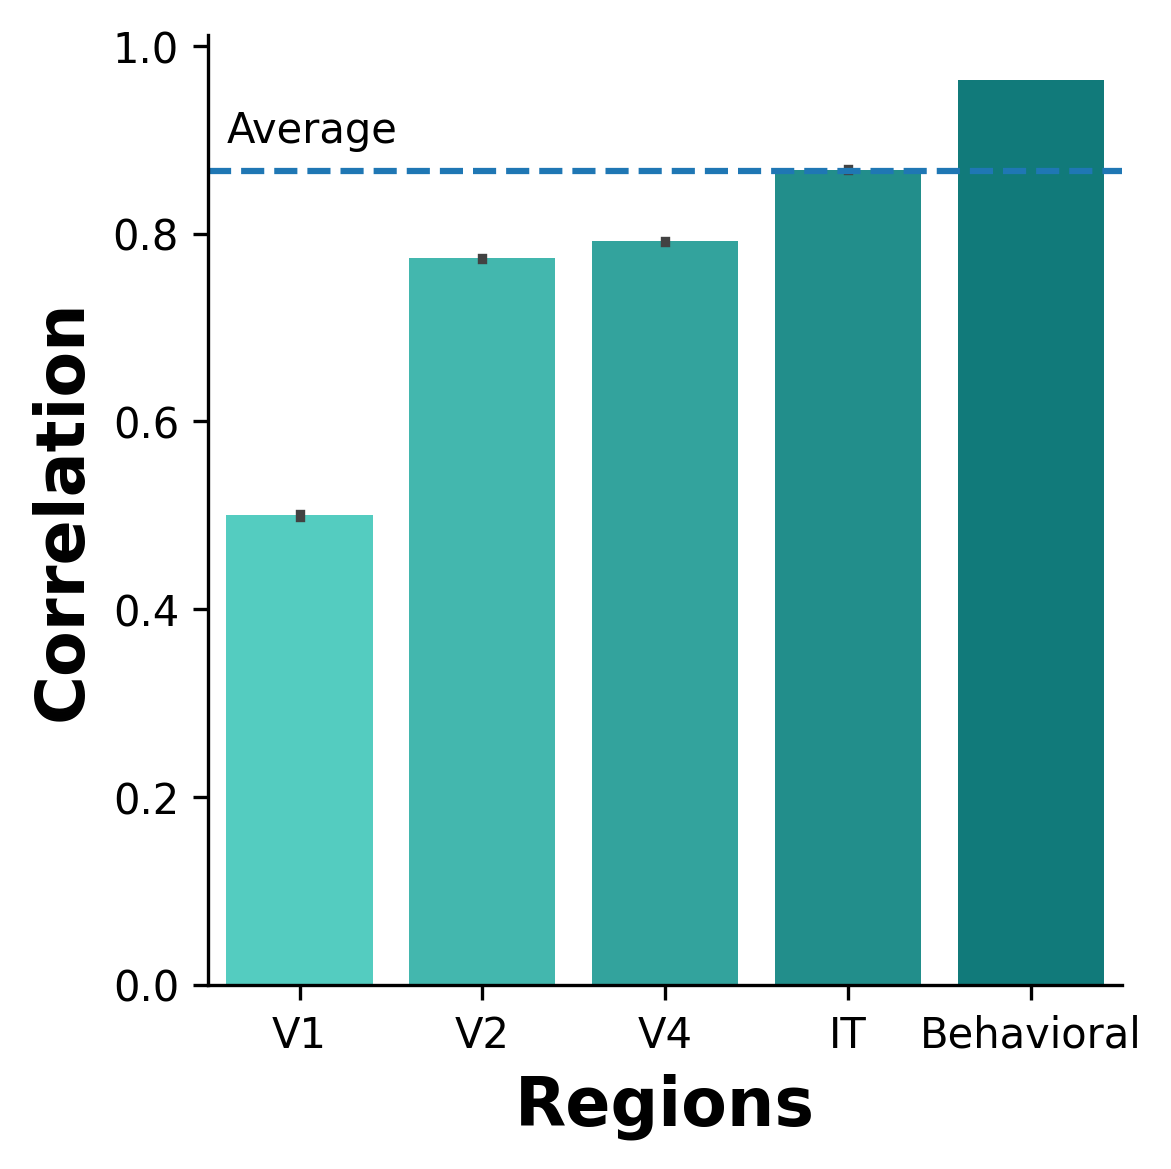

In [19]:
figsize = (8, 8)
figsize = (fig_multiplier * figsize[0], fig_multiplier * figsize[1])
fig, axes = plt.subplots(1, 1, figsize=figsize, dpi=300)
ax = axes



df_plot = df_fits[df_fits.region != 'Average'].copy()
sns.barplot(data=df_plot, hue='region', x='region', y='rvalue', ax=ax, palette=color_palette_regions, errorbar=('ci', 95))

### Average
ax.axhline(avg_r, 0, 1, linestyle='--', label='Average')
ax.text(0.02, avg_r+0.03, "Average", transform=ax.get_yaxis_transform())


ax.set_xlabel('FLOPs')
ax.set_ylabel('Alignment')
ax.set_xlabel('Regions', fontsize=16, fontweight='bold')
ax.set_ylabel('Correlation', fontsize=16, fontweight='bold')


ax.legend().remove()
ax.spines[['right', 'top']].set_visible(False)
ax.grid(False)




plt.tight_layout()


figures_dir = '../figures'
fig_name = 'fig6_corr_bar'
formats = ['pdf', 'png', 'svg']
save_figs(figures_dir, fig_name, formats=formats)